In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys
# import tqdm
import torch

from torch.utils.tensorboard import SummaryWriter

from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')
import src.mace.autoencoder  as ae
import src.mace.dataset      as ds
import src.mace.train        as tr
import src.mace.neuralODE    as nODE
import src.mace.plotting     as pl
import src.mace.loss         as loss

%reload_ext autoreload
%autoreload 2

In [9]:
i=466

x = torch.randn(1,10,i)
# x = torch.swapaxes(x,1,2)
x_hat = torch.randn(1,10,i)
# x_hat = torch.swapaxes(x_hat,1,2)
# print('shape',x.shape[1])
# print('x    ',x)
x_0 = x[:,0,:]
# print('x0   ',x_0)
# print('diff ',x-x_0)
# print('--')

x_hat =x_hat[:,1:,:]
x = x[:,1:,:]
# print(x_0)
# print('y    ',x_hat.shape)
loss = ((x_hat-x_0)/(x-x_0))**2
mse = tr.mse_loss(x,x_hat)

print(mse.shape)
print(mse[:,-1,:])
print(mse[:,-1,:].view(-1))

torch.Size([1, 9, 466])
tensor([[8.6454e-03, 1.3754e+00, 5.3146e+00, 5.5905e-01, 1.7726e+00, 5.6800e-01,
         2.3927e+00, 2.1374e-01, 4.2060e-01, 2.8645e+00, 4.0833e+00, 6.7626e+00,
         1.9803e+00, 2.9409e-01, 1.9289e+00, 1.8691e-01, 1.0467e+01, 4.5945e-01,
         2.5112e-01, 1.4262e-01, 5.1733e-01, 2.2355e-01, 5.6686e-02, 5.4500e-02,
         3.1645e+00, 2.7626e-01, 2.5485e-01, 1.2677e-01, 4.5274e-02, 5.0127e-01,
         4.1545e-02, 4.0045e+00, 1.6979e+00, 1.1241e+01, 3.9128e+00, 8.9546e+00,
         1.0739e-01, 1.6148e+00, 1.0316e+01, 9.9428e-01, 1.2149e+01, 2.8669e-01,
         2.1727e-01, 4.9604e+00, 7.7270e-01, 2.2271e-01, 5.5551e-01, 7.3696e-02,
         1.6719e+00, 2.7089e+00, 3.0442e-02, 4.6525e+00, 1.8880e+00, 1.1439e+01,
         1.2527e-01, 1.8274e-02, 2.7958e-01, 3.8935e+00, 3.9335e-01, 1.5597e+00,
         2.9021e+00, 5.2105e+00, 1.0945e+00, 7.7929e+00, 2.1162e+00, 1.0646e-01,
         4.6382e+00, 8.2644e+00, 8.4675e-02, 4.7184e+00, 7.1403e-01, 2.3625e-01,
    

In [35]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 1 ## if not 1, dan kan er geen tensor van gemaakt worden


kwargs = {'num_workers': 1, 'pin_memory': True} 


lr = 1.e-3
tot_epochs = 10
nb_epochs  = 5
ini_epochs = 2
losstype = 'rel'
z_dim = 10
dt_fract = 0.2
# dirname = 'C-short-dtime'
# dirname = 'new'
dirname = 'easy-mace2'


train, test, data_loader, test_loader = ds.get_data(dirname = dirname,dt_fract=dt_fract, batch_size=batch_size, kwargs=kwargs)
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=466, DEVICE = DEVICE)


Dataset:
------------------------------
total # of samples: 100
# training samples: 70
#  testing samples: 30
             ratio: 0.3


In [36]:
norm = {'mse' : 1,
        'rel' : 1,
        'evo' : 1}

fract = {'mse' : 1, 
         'rel' : 1,
         'evo' : 1}


## Make loss objects
trainloss = loss.Loss(norm, fract)
testloss  = loss.Loss(norm, fract)

trainloss.set_losstype(losstype)
testloss.set_losstype(losstype)


trainloss, testloss = tr.train(model, lr, data_loader, test_loader,None, end_epochs = ini_epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, plot = False, log = True, show = True)

Model:         
learning rate: 0.001

>>> Training model...

	batch 70 / 70

	batch 30 / 30
Epoch 1 complete! 	Average loss train:  1.5381171526105264e+16 	Average loss test:  362544013386274.1

	batch 70 / 70

	batch 30 / 30
Epoch 2 complete! 	Average loss train:  1586504483254155.0 	Average loss test:  54470464154282.664

 	DONE!


In [33]:
trainloss.get_loss('rel')

array([1.35132133e+16, 1.81634577e+15])

In [3]:
## Training & validating model

loss_train_all_nn, loss_test_all_nn, status_all_nn = tr.train(model_nn, lr, data_loader, test_loader, epochs, DEVICE, loss_type)
n_test_nn, n_test_hat_nn, tstep_nn, loss_nn, mace_time = tr.test(model_nn, test_loader, DEVICE, loss_type)

print('\n', status_all_nn)

Model:         
learning rate: 0.001

>>> Training model...

	batch 4638 / 4638
Epoch 1 complete! 	Average loss train:  0.0005003402308617158 	Average loss test:  0.0001752580574247986
 	DONE!

>>> Testing model...
	batch 1 / 1988 , # nan 0
Test loss: 0.0001752580574247986

 [0]


In [34]:
plt.plot(idv_mse)
plt.plot(idv_rel, '--')

plt.yscale('log')
plt.show()


NameError: name 'idv_mse' is not defined

### Computation time

In [ ]:
chempy_time = list()
for i in range(1988):
    chempy_time.append(test.tictoc(i))

print(chempy_time)

In [56]:
j=0
for i in range(len(mace_time)):
    if mace_time[i] == -1:
        # print(i)
        j+=1
        mace_time[i] = mace_time[i-1]
print(j)

106


In [57]:
print(mace_time)

[0.006859302520751953, 0.004934549331665039, 0.005250215530395508, 0.0051763057708740234, 0.0049288272857666016, 0.004896402359008789, 0.004584789276123047, 0.0036029815673828125, 0.0036029815673828125, 0.00403904914855957, 0.0038216114044189453, 0.0038216114044189453, 0.00440216064453125, 0.003566741943359375, 0.003587007522583008, 0.004163503646850586, 0.004467487335205078, 0.004831790924072266, 0.004441261291503906, 0.004558086395263672, 0.004684925079345703, 0.004130363464355469, 0.0036439895629882812, 0.0037381649017333984, 0.0037276744842529297, 0.0038368701934814453, 0.005636453628540039, 0.002910614013671875, 0.0028579235076904297, 0.00413823127746582, 0.0042972564697265625, 0.004592418670654297, 0.004405498504638672, 0.004601001739501953, 0.0037221908569335938, 0.004120349884033203, 0.003733396530151367, 0.0038444995880126953, 0.004955768585205078, 0.004637002944946289, 0.0039014816284179688, 0.004017353057861328, 0.004181623458862305, 0.004877567291259766, 0.00508499145507812

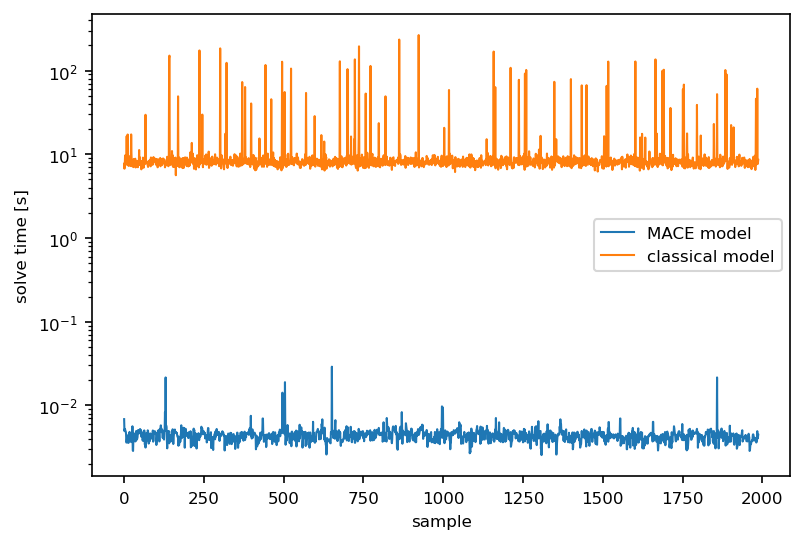

In [59]:
fig = plt.figure(figsize = (6,4))
ax1 = fig.add_subplot((111))


lw = 1
ax1.plot(mace_time, lw = lw,label = 'MACE model')
ax1.plot(time, lw=lw,label = 'classical model')

ax1.set_xlabel('sample')
ax1.set_ylabel('solve time [s]')

# ax1.set_ylim([1e-3,1e3])
ax1.set_yscale('log')

plt.legend()

### Analysis the test data

In [5]:
def unscale(x, min, max):

    unscaled = x*np.abs(max-min)+min

    return unscaled

In [15]:
n_test

tensor([[[0.9038, 0.7599, 0.7182,  ..., 0.5977, 0.5977, 0.5977],
         [0.9038, 0.7599, 0.7182,  ..., 0.5977, 0.5977, 0.5977],
         [0.9038, 0.7599, 0.7182,  ..., 0.5977, 0.5977, 0.5977],
         ...,
         [0.9038, 0.7599, 0.7182,  ..., 0.5977, 0.5977, 0.5977],
         [0.9038, 0.7599, 0.7182,  ..., 0.5977, 0.5977, 0.5977],
         [0.9038, 0.7599, 0.7182,  ..., 0.5977, 0.5977, 0.5977]]])

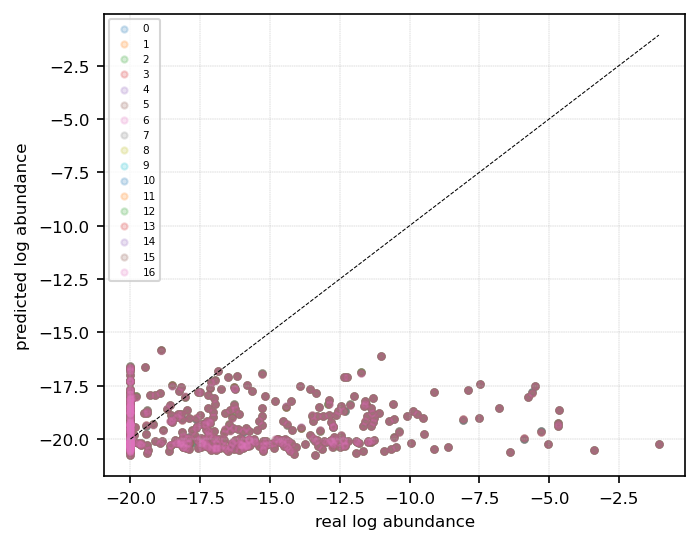

In [6]:
i = 4
cutoff = 1e-20
nmin = np.log10(cutoff)
nmax = np.log10(0.85e-1)

x = unscale(np.linspace(0,1,100), nmin, nmax)

fig = plt.figure(figsize = (5,4))
ax1 = fig.add_subplot((111))

n_un = unscale(n_test,nmin, nmax)
nhat_un = unscale(n_test_hat,nmin, nmax)

# ax1.set_title(spec, fontsize = 7)

for i in range(n_test.shape[1]):
    ax1.scatter(n_un[0][i],nhat_un[0][i],marker = '.', alpha = 0.2, label = i) # type: ignore

ax1.plot(x,x, '--k', lw = 0.5)

ax1.set_xlabel('real log abundance')
ax1.set_ylabel('predicted log abundance')

# bounds = [0.56, 1.11]
# ax1.set_xlim(bounds)
# ax1.set_ylim(bounds)

ax1.grid(True, linestyle = '--', linewidth = 0.2)

ax1.legend(fontsize = 5)

plt.show()

In [30]:
name = '2023-09-28 15:39:53.615386/'
PATH = '/STER/silkem/MACE/models/'+name+'enc.pt'

model_load = nODE.Solver(p_dim=4,z_dim = 10, n_dim=466, DEVICE = DEVICE)
model_load.load_state_dict(torch.load(PATH))
# print(model_load.state_dict())

OrderedDict([('g.A', tensor([[-0.2498,  0.6358,  1.0281,  1.3105,  1.1966, -0.0294,  0.3544, -1.5499,
          0.6266,  0.2321],
        [ 0.2553, -0.2870, -0.3010,  0.4708, -0.6642, -1.0672,  0.6984, -0.3317,
         -1.3807,  1.8656],
        [-1.2603, -0.4429,  0.8608,  0.7221, -1.2014, -1.1542, -1.0853,  0.7384,
         -1.8552, -0.2633],
        [-1.5659, -0.3241,  0.4576,  0.5749, -0.7852, -1.1421, -0.9282,  1.2607,
          2.6327,  0.4957],
        [-0.9298, -0.1865,  1.3592,  0.5789, -0.4429, -0.1374, -0.2800,  1.2148,
         -0.9497, -0.6912],
        [ 1.9436,  0.3400,  0.7957, -1.6331, -0.6393, -1.4172, -1.7040,  0.1753,
          0.0679, -1.6194],
        [-0.6759, -1.2743,  0.4158, -1.2229,  0.4883,  0.3104, -0.1091,  0.1266,
         -0.3459, -1.5492],
        [-0.3927,  1.5786, -2.1363,  0.7834,  1.0361,  1.1879,  0.5978, -0.5691,
          0.1285,  1.1339],
        [ 2.3071, -0.4775, -0.5447,  0.0905,  0.8159,  0.5948,  1.7800, -1.3825,
         -0.7512,  0.9067]

In [45]:
def compare_abs(n, n_hat, tstep, molecs):

    n_i = unscale(n.view(n.shape[1], -1), train.n_min, train.n_max)
    n_hat = unscale(n_hat.view(n_hat.shape[1], -1), train.n_min, train.n_max)
    t = unscale(tstep.view(tstep.shape[1], -1),train.dt_min, train.dt_max)

    fig, ax = plt.subplots(3,1, gridspec_kw={'height_ratios': [5,2,2]},figsize=(5,6))
    ax1 = ax[0]
    ax2 = ax[1]
    ax3 = ax[2]
    axs = [ax1,ax2, ax3]

    for mol in molecs:
        ax1.plot(t, n_i[:,mol]  , '-x',label = 'real')
        ax2.plot(t, n_hat[:,mol], '-x',label = 'predicted')


    plt.xscale('log')
    plt.legend()
    plt.show()

In [46]:
compare_abs(n_test, n_test_hat, tstep)

AttributeError: 'Data' object has no attribute 'n_min'

### Testing seperately

In [4]:
enc = ae.Encoder( 470, 100, 10)
dec = ae.Decoder(10,100,466)

i = 849
n_test = train[i][0]
n_0    = n_test[:,0]
p      = train[i][1]
t      = train[i][2]

In [11]:
for p in enc.parameters():
    p.requires_grad_(False)
    print(p.requires_grad)


False
False
False
False


In [5]:
t

tensor([-2.4605e-06, -2.1805e-06, -1.9006e-06,  8.9903e-07,  3.6986e-06,
         3.1695e-05,  5.9691e-05,  3.1945e-04,  5.7921e-04,  8.3896e-04,
         1.5936e-03,  2.3481e-03,  2.7568e-03])

In [14]:
z_0= enc(torch.cat((p, n_0), axis=0))

z_0

tensor([ 0.0922,  0.0054, -0.0003,  0.0963,  0.0684, -0.0162,  0.0080, -0.0013,
        -0.0047, -0.0070], grad_fn=<LeakyReluBackward0>)

In [5]:
torch.cat((p, n_0), axis=0).shape

torch.Size([470])

In [15]:
g = nODE.G(4,10)
# z = z_0.view(1,10)
# g_fun = nODE.G.forward(g,t,z,p)
# print(g_fun)

In [ ]:
A = nODE.A(466, 10)
print(A.layer_out.bias.data)

tensor([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.])


In [ ]:
A = model.g.a(p)
# torch.linalg.eig(A)
print(A)

tensor([[-0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.2000,  0.0000],
        [ 0.0000,  

In [ ]:
n_s = model(n_0, p, t.view(1,-1))
n_s

status        tensor([0])


tensor([[[-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         ...,
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120],
         [-0.0060, -0.0126,  0.0307,  ..., -0.0262,  0.0414, -0.0120]]],
       grad_fn=<ReshapeAliasBackward0>)